# DAMI project (Group 9)
Task:
1. Implementation of DBSCAN-Tanimoto Similarity
2. Implementation of DBSCANRN-Tanimoto Similarity (Naive & Opt)
3. Clustering quality measures: Purity, Rand, Davies−Bouldin and Silhouette Coefficient 

**PDF report:**
https://github.com/rauzansumara/dbscan-and-dbscanrn-tanimoto-distance

Requirements
```
python==3.8.5
numpy==1.21.4
pandas==1.3.5
sklearn==0.24.2
matplotlib==3.3.2
```

Clustering is one of the most important tasks of both artificial intelligence and data mining. That is a way to group a set of data points in a way that similar data points are grouped together. There are different approaches and algorithms to perform clustering tasks which is of them is algorithms based on density clustering. Based on discussed in the lecture, we will implement algorithms of Density-Based Spatial Clustering of Applications with Noise (DBSCAN) and Density-based spatial clustering using reverse nearest neighbors (DBSCRN). 

However, noted during project consultations, there are some inconsistencies in the paper presenting the pseudo-code of the DBSCRN algorithm [1]. For this reason, we will implement some modification of DBSCRN (which will be called DBSCANRN) instead of DBSCRN. In DBSCANRN, we will keep core point and non-core points definitions as given in the pseudo-code of DBSCRN. Namely, a point is considered as a DBSCRN (and by this DBSCANRN) non-core point if the number of their reverse k-nearest neighbors is less than k (lines 2-3 in the DBSCRN pseudo-code). Otherwise, it is considered as a core point (line 5 in the DBSCRN pseudo-code). We implement DBSCANRN in a way similar to NBC, except that instead of adding k+-nearest neighbors of a core point to a cluster, its reverse k-nearest neighbors will be added to the cluster.


**Similarity Measures**

The Tanimoto similarity is commonly used in bio-informatics or biology, and information retrieval to identify neighborhoods of sufficiently similar items or the k most similar things represented by real-valued vectors. The triangle inequality condition is frequently used to rapidly discover vectors that may belong to the targeted neighborhood of a given vector for metrics such as the Euclidean distance. However, the Tanimoto similarity and Tanimoto dissimilarity do not satisfy the triangle inequality property for real-valued vectors [2]. Considering this, another way to find a neighborhood with regard to Tanimoto similarity among real-valued vectors has been explained in [2]. We will adopt it, using bounds on vector lengths to calculate Tanimoto similarity ε-neighborhoods

# 1) Code Implementation

In [ ]:
# following libraries are required for this project
import numpy as np                
import pandas as pd   
from scipy.io import arff
from sklearn import metrics          
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA

# following built-in libraries are required
import os
import time
from functools import wraps
from bisect import bisect_right, insort
from typing import Callable, TypeVar, List, Tuple

### 1. DBSCAN - Tanimoto Similarity

DBSCAN defines the neighborhood of a data point $o$ by a user specified parameter $\epsilon$,  which includes all data points within this radius from the center of $o$. The density of this $\epsilon$-neighborhood is simply the number of objects in it.

In [27]:
def DBSCAN(Data, eps, MinPts):
    '''
    Cluster the dataset `D` using the DBSCAN algorithm.
    
    dbscan takes a dataset `D` (a list of vectors), a threshold distance
    `eps`, and a required number of points `MinPts`.
    
    It will return a list of cluster labels. The label -1 means noise, and then
    the clusters are numbered starting from 1.
    '''
    t0 = time.time()  # measure operation time 0

    D = np.asarray(Data.iloc[:,:-1])

    # This list will hold the final cluster assignment for each point in D.
    # There are two reserved values:
    #    -1 - Indicates a noise point
    #    -2 - Means the point hasn't been considered yet.
    # Initially all labels are 0.    
    labels = [-2]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    # This outer loop is just responsible for picking new seed points--a point
    # from which to grow a new cluster.
    # Once a valid seed point is found, a new cluster is created, and the 
    # cluster growth is all handled by the 'expandCluster' routine.
    
    # For each point P in the Dataset D...
    # ('P' is the index of the datapoint, rather than the datapoint itself.)

    core = [-1] * len(D) # Type: 1 core, 0 border, -1 noise - new
    
    t1 = time.time()  # measure operation time 1

    for P in range(0, len(D)):
    
        # Only points that have not already been claimed can be picked as new 
        # seed points.    
        # If the point's label is not 0, continue to the next point.
        if not (labels[P] == -2):
            continue
        
        # Find all of P's neighboring points.
        NeighborPts = region_query(D, P, eps)
        
        # If the number is below MinPts, this point is noise. 
        # This is the only condition under which a point is labeled 
        # NOISE--when it's not a valid seed point. A NOISE point may later 
        # be picked up by another cluster as a boundary point (this is the only
        # condition under which a cluster label can change--from NOISE to 
        # something else).
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the 
        # seed for a new cluster.    
        else: 
           core[P] = 1 #new
           expand_cluster(D, labels, P, NeighborPts, C, eps, MinPts, core)
           C += 1
    
    t2 = time.time() # measure operation time 2  

    # All data has been clustered!
    result = Data.assign(TypeId=core)
    result['ClId'] = labels

    # create dictionary for datesets
    root_path = 'save_file'
    os.makedirs(root_path, exist_ok=True)

    name = [x for x in globals() if globals()[x] is Data][0]
    result.to_csv(f'save_file/OUT_dbscan_{name}_D{D.shape[1]}_R{len(D)}_Eps{eps}_MinPts{MinPts}.csv', index=False)
    
    t3 = time.time()  # measure operation time 3

    return (result, [t1-t0, t2-t1, t3-t2, t3-t0]) # time: Read/Initial data, Clustering, Save, Total


def expand_cluster(D, labels, P, NeighborPts, C, eps, MinPts, core):
    '''
    Grow a new cluster with label `C` from the seed point `P`.
    
    This function searches through the dataset to find all points that belong
    to this new cluster. When this function returns, cluster `C` is complete.
    
    Parameters:
      `D`      - The dataset (a list of vectors)
      `labels` - List storing the cluster labels for all dataset points
      `P`      - Index of the seed point for this new cluster
      `NeighborPts` - All of the neighbors of `P`
      `C`      - The label for this new cluster.  
      `eps`    - Threshold distance
      `MinPts` - Minimum required number of neighbors
    '''

    # Assign the cluster label to the seed point.
    labels[P] = C

    # Look at each neighbor of P (neighbors are referred to as Pn). 
    # NeighborPts will be used as a FIFO queue of points to search--that is, it
    # will grow as we discover new branch points for the cluster. The FIFO
    # behavior is accomplished by using a while-loop rather than a for-loop.
    # In NeighborPts, the points are represented by their index in the original
    # dataset.
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        # If Pn was labelled NOISE during the seed search, then we
        # know it's not a branch point (it doesn't have enough neighbors), so
        # make it a leaf point of cluster C and move on.
        if labels[Pn] == -1:
           labels[Pn] = C
           core[Pn] = 0 #new
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == -2:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = region_query(D, Pn, eps)
            
            # If Pn has at least MinPts neighbors, it's a branch point!
            # Add all of its neighbors to the FIFO queue to be searched. 
            if len(PnNeighborPts) >= MinPts:
                NeighborPts = NeighborPts + PnNeighborPts
                core[Pn] = 1 #new

            elif (len(PnNeighborPts) > 0): #new
                core[Pn] = 0 #new

            # If Pn *doesn't* have enough neighbors, then it's a leaf point.
            # Don't queue up it's neighbors as expansion points.
            #else:
                # Do nothing                
                #NeighborPts = NeighborPts               
        
        # Advance to the next point in the FIFO queue.
        i += 1        
    
    # We've finished growing cluster C!


def region_query(D, P, eps):
    '''
    Find all points in dataset `D` within distance `eps` of point `P`.
    
    This function calculates the distance between a point P and every other 
    point in the dataset, and then returns only those points which are within a
    threshold distance `eps`.
    '''
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        
        # If the distance is below the threshold, add it to the neighbors list.
        if tanimoto_sim(D[P], D[Pn]) > eps:
           neighbors.append(Pn)
            
    return neighbors

### 2. DBSCANRN - Tanimoto Similarity

#### Non-Optimized Version

In [226]:
KNN = List[Tuple[float, int]]
KNNS = List[KNN]
R_KNNS = List[List[int]]
LEN_RKNNS = List[float]
CLUSTER = List[int]


def distance(a: np.array, b: np.array) -> float:
  return np.linalg.norm(a - b)


def tanimoto_sim(a: np.array, b: np.array) -> float:
  return (np.inner(a,b)/(np.inner(a,a) + np.inner(b,b) - np.inner(a,b)))


def k_neighbourhood(data: np.ndarray, k: int) -> Tuple[KNNS, R_KNNS]:
  knns: List[List[Tuple[float, int]]] = [list() for _ in range(len(data))]
  r_knns: List[List[int]] = [list() for _ in range(len(data))]

  for idx1, v1 in enumerate(data):
    neighbour_candidates = []
    for idx2, v2 in enumerate(data):
      if idx1 != idx2:
        dist = tanimoto_sim(v1, v2)
        #dist = distance(v1, v2)
        neighbour_candidates.append((dist, idx2))
    neighbour_candidates.sort(key=lambda t: t[0], reverse=True)
    eps = neighbour_candidates[:k][-1][0]

    neighbours = []
    for nc in neighbour_candidates:
      if nc[0] < eps: # probably there are points with the same similarly, we need to check!
        break
      neighbours.append(nc)

    knns[idx1] = neighbours
    for nc in knns[idx1]:
      r_knns[nc[1]].append(idx1)

  return knns, r_knns

#### Optimized Version

In [399]:
T = TypeVar('T')
def insort_right(data: List[T], item: T, key: Callable[[str], int]):
  keys = [key(r) for r in data]
  data.insert(bisect_right(keys, key(item)), item)


class OptkNeighborhoodIndex():

  def __init__(self, data: np.array, dimensions: int, k: int = 3) -> None:
    assert k <= len(data), '`k` is greater than the length of `data`'

    self._k = k
    self._r: np.array = np.zeros(dimensions)
    self._data = data
    self._dists = self.create_est_dist_list()

  def run(self):
    knns: KNNS = [list() for _ in range(len(self._data))]
    r_knns: R_KNNS = [list() for _ in range(len(self._data))]

    for i, item in enumerate(self._dists):
      _, idx = item
      knns[idx] = self.opt_k_neighborhood(i)
      for n in knns[idx]:
        r_knns[n[1]].append(idx)

    return knns, r_knns

  def interval(self, idx: int, e: float) -> Tuple[float, float]:
    alfa = (1/2)*((1+1/e)+np.sqrt((1+1/e)**2-4))
    return ((1/alfa)*self._dists[idx][0], alfa*self._dists[idx][0]) # (lcl, ucl)

  def opt_k_neighborhood(self, p_idx: int) -> np.array:
    knn: KNN = []

    i = 0
    eps = []
    lcl = self._dists[0][0]
    ucl = self._dists[len(self._dists) - 1][0]
    b_idx = p_idx
    f_idx = p_idx
    
    b_idx, backwardSearch = self.preceding_point(b_idx)
    f_idx, forwardSearch = self.following_point(f_idx)

    knn, b_idx, f_idx, backwardSearch, forwardSearch, i, lcl, ucl, eps = self.find_first_kcn_fb(
        knn,
        p_idx,
        b_idx,
        f_idx,
        backwardSearch,
        forwardSearch,
        i,
        lcl,
        ucl,
        eps,
    )
    knn, b_idx, backwardSearch, i, lcl, eps = self.find_first_kcn_b(
        knn,
        p_idx,
        b_idx,
        backwardSearch,
        i,
        lcl,
        eps,
    )
    knn, f_idx, forwardSearch, i, ucl, eps = self.find_first_kcn_f(
        knn,
        p_idx,
        f_idx,
        forwardSearch,
        i,
        ucl,
        eps,
    )
    knn, b_idx, backwardSearch, lcl, eps = self.verify_k_condidate_neighbours_backward(
        knn,
        p_idx,
        b_idx,
        backwardSearch,
        lcl,
        eps,
    )
    knn, f_idx, forwardSearch, ucl, eps = self.verify_k_condidate_neighbours_forward(
        knn,
        p_idx,
        f_idx,
        forwardSearch,
        ucl,
        eps,
    )

    return knn

  def preceding_point(self, idx) -> Tuple[int, bool]:
    if idx > 0:
      return (idx - 1, True)
    else:
      return (idx, False)

  def following_point(self, idx) -> Tuple[int, bool]:
    if idx < (len(self._dists) - 1):
      return (idx + 1, True)
    else:
      return (idx, False)

  def find_first_kcn_fb(
      self,
      knn: KNN,
      p_idx: int,
      b_idx: int,
      f_idx: int,
      backwardSearch: bool,
      forwardSearch: bool,
      i: int,
      lcl: float,
      ucl: float,
      eps: list,
  ) -> Tuple[KNN, int, int, bool, bool, int, float, float, list]:
    while backwardSearch and forwardSearch and (i < self._k):
      if (self._dists[p_idx][0] - self._dists[b_idx][0]) < (self._dists[f_idx][0] - self._dists[p_idx][0]):
        dist = self.calc_real_sim(b_idx, p_idx)
        i += 1
        insort_right(knn, (dist, self.get_idx_from_dist(b_idx)), key=lambda x: x[0])
        b_idx, backwardSearch = self.preceding_point(b_idx)
        insort(eps, dist)
        lcl, ucl = self.interval(p_idx, min(eps))
      else:
        dist = self.calc_real_sim(f_idx, p_idx)
        i += 1
        insort_right(knn, (dist, self.get_idx_from_dist(f_idx)), key=lambda x: x[0])
        f_idx, forwardSearch = self.following_point(f_idx)
        insort(eps, dist)
        lcl, ucl = self.interval(p_idx, min(eps))

    return (knn, b_idx, f_idx, backwardSearch, forwardSearch, i, lcl, ucl, eps)

  def find_first_kcn_b(
      self,
      knn: KNN,
      p_idx: int,
      b_idx: int,
      backwardSearch: bool,
      i: int,
      lcl: float,
      eps: list,
  ) -> Tuple[KNN, int, bool, int, list]:
    while backwardSearch and (i < self._k):
      dist = self.calc_real_sim(b_idx, p_idx)
      i += 1
      insort_right(knn, (dist, self.get_idx_from_dist(b_idx)), key=lambda x: x[0])
      b_idx, backwardSearch = self.preceding_point(b_idx)
      insort(eps, dist)
      lcl, _ = self.interval(p_idx, min(eps))

    return (knn, b_idx, backwardSearch, i, lcl, eps)

  def find_first_kcn_f(
      self,
      knn: KNN,
      p_idx: int,
      f_idx: int,
      forwardSearch: bool,
      i: int,
      ucl: float,
      eps: list,
  ) -> Tuple[KNN, int, bool, int, float, list]:
    while forwardSearch and (i < self._k):
      dist = self.calc_real_sim(f_idx, p_idx)
      i += 1
      insort_right(knn, (dist, self.get_idx_from_dist(f_idx)), key=lambda x: x[0])
      f_idx, forwardSearch = self.following_point(f_idx)
      insort(eps, dist)
      _, ucl = self.interval(p_idx, min(eps))

    return (knn, f_idx, forwardSearch, i, ucl, eps)

  def verify_k_condidate_neighbours_backward(self, knn: KNN, p_idx: int, b_idx: int, backwardSearch: bool,
                                             lcl: float, eps: list) -> Tuple[KNN, int, bool, float, list]:
    while backwardSearch and (lcl <= self._dists[b_idx][0]):
      dist = self.calc_real_sim(b_idx, p_idx)
      mineps = eps[0]
      if dist > mineps:
        #eps.remove(mineps)
        i_list = [n for n in knn if n[0] == mineps]
        i = len(i_list)
        if (len(knn) - i) >= (self._k - 1):
          eps.remove(mineps)
          knn = [e for e in knn if e not in i_list]
          insort_right(knn, (dist, self.get_idx_from_dist(b_idx)), key=lambda x: x[0])
          insort(eps, dist)
          lcl, _ = self.interval(p_idx, min(eps))
        else:
          insort_right(knn, (dist, self.get_idx_from_dist(b_idx)), key=lambda x: x[0])
      elif dist == mineps:
        insort_right(knn, (dist, self.get_idx_from_dist(b_idx)), key=lambda x: x[0])

      b_idx, backwardSearch = self.preceding_point(b_idx)

    return (knn, b_idx, backwardSearch, lcl, eps)

  def verify_k_condidate_neighbours_forward(self, knn: KNN, p_idx: int, f_idx: int, forwardSearch: bool,
                                            ucl: float, eps: list) -> Tuple[KNN, int, bool, float, list]:
    while forwardSearch and (self._dists[f_idx][0] <= ucl):
      dist = self.calc_real_sim(f_idx, p_idx)
      mineps = eps[0]
      if dist > mineps:
        #eps.remove(mineps)
        i_list = [n for n in knn if n[0] == mineps]
        i = len(i_list)
        if (len(knn) - i) >= (self._k - 1):
          eps.remove(mineps)
          knn = [e for e in knn if e not in i_list]  
          insort_right(knn, (dist, self.get_idx_from_dist(f_idx)), key=lambda x: x[0])
          insort(eps, dist)
          _, ucl = self.interval(p_idx, min(eps))
        else:
          insort_right(knn, (dist, self.get_idx_from_dist(f_idx)), key=lambda x: x[0])
      elif dist == mineps:
        insort_right(knn, (dist, self.get_idx_from_dist(f_idx)), key=lambda x: x[0])

      f_idx, forwardSearch = self.following_point(f_idx)
    
    return (knn, f_idx, forwardSearch, ucl, eps)

  def get_idx_from_dist(self, idx) -> int:
    return self._dists[idx][1]

  def calc_real_sim(self, idx_1, idx_2) -> float:
    return tanimoto_sim(self._data[self.get_idx_from_dist(idx_1)], self._data[self.get_idx_from_dist(idx_2)])
   #return distance(self._data[self.get_idx_from_dist(idx_1)], self._data[self.get_idx_from_dist(idx_2)])

  def create_est_dist_list(self) -> KNN:
    dist: KNN = []

    for idx, point in enumerate(self._data):
      dist.append((distance(self._r, point), idx))

    return sorted(dist, key=lambda x: x[0])

In [389]:
EMPTY_CLUSTER = -1

def DBSCANRN(Data: pd.DataFrame, k: int, opt: False) -> Tuple[pd.DataFrame, List[float]] :
  
  t0 = time.time()  # measure operation time 0

  clusters: CLUSTER = [EMPTY_CLUSTER] * len(Data)

  data = np.asarray(Data.iloc[:,:-1])
  dimensions = data.shape[1]

  t1 = time.time()  # measure operation time 1

  if opt:
    optknn = OptkNeighborhoodIndex(data, dimensions, k)
    knns, r_knns = optknn.run()
  else:
    knns, r_knns = k_neighbourhood(data, k)

  len_rknn = calc_len_rknn(r_knns)
  
  t2 = time.time()  # measure operation time 2

  core = [-1] * len(data) # Type: 1 core, 0 border, -1 noise - new
  
  # Extand Cluster
  current_cluster_id = 0
  for idx, _ in enumerate(data):
    if has_cluster(idx, clusters) or not is_greater_k(idx, k, len_rknn):
      continue
    clusters[idx] = current_cluster_id
    core[idx] = 1 #new
    dense_points = set()

    for n_idx in r_knns[idx]:
      clusters[n_idx] = current_cluster_id
      if is_greater_k(n_idx, k, len_rknn):
        dense_points.add(n_idx)
        core[n_idx] = 1 #new
      else: #new
        core[n_idx] = 0 #new

    while dense_points:
      dp = dense_points.pop()
      for n_idx in r_knns[dp]:
        if has_cluster(n_idx, clusters):
          continue
        clusters[n_idx] = current_cluster_id
        if is_greater_k(n_idx, k, len_rknn):
          dense_points.add(n_idx)
          core[n_idx] = 1 #new
        else:
          core[n_idx] = 0 #new

    current_cluster_id += 1

  t3 = time.time() # measure operation time 3

  # All data has been clustered!
  result = Data.assign(TypeId=core)
  result['ClId'] = clusters

  # create dictionary for datesets
  root_path = 'save_file'
  os.makedirs(root_path, exist_ok=True)
  
  name = [x for x in globals() if globals()[x] is Data][0]
  result1 = pd.DataFrame({'minEps': [r[-1][0] for idx, r in enumerate(knns)], 
                          'maxEps': [r[0][0] for idx, r in enumerate(knns)], 
                          '|rknn|': len_rknn, 'knn': knns, 'rknn': r_knns})
  # Save result
  if opt:
    result.to_csv(f'save_file/OUT_Opt_dbscanrn_{name}_D{data.shape[1]}_R{len(data)}_k{k}.csv', index=False)
    result1.to_csv(f'save_file/DEBUG_Opt_dbscanrn_{name}_D{data.shape[1]}_R{len(data)}_k{k}.csv', index=False)
  else:
    result.to_csv(f'save_file/OUT_dbscanrn_{name}_D{data.shape[1]}_R{len(data)}_k{k}.csv', index=False)
    result1.to_csv(f'save_file/DEBUG_dbscanrn_{name}_D{data.shape[1]}_R{len(data)}_k{k}.csv', index=False)

  t4 = time.time() # measure operation time 4

  return (result, [t1-t0, t2-t1, t3-t2, t4-t3, t4-t0]) # time: Read/Initial data, kNN/rkNN, Clustering, Save, Total


def calc_len_rknn(r_knns: R_KNNS) -> LEN_RKNNS:
  return [len(rknn) for idx, rknn in enumerate(r_knns)]


def is_greater_k(idx: int, k: int, len_rknn: LEN_RKNNS) -> bool:
  return len_rknn[idx] >= k


def has_cluster(idx: int, clusters: CLUSTER) -> bool:
  return clusters[idx] != EMPTY_CLUSTER

### 3. Clustering Quality Measures

In [17]:
# calculate Purity index
def get_purity_index(df):
    real_c = df.iloc[:,-3]
    pred_c = df.iloc[:,-1]
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(real_c, pred_c)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 


# calculate rand index
def get_rand_index(df):
    real_c = df.iloc[:,-3]
    pred_c = df.iloc[:,-1]
    ri = metrics.rand_score(real_c, pred_c)
    return ri


# calculate Davies−Bouldin index
def get_davies_bouldin_index(df):
    X = df.iloc[:,:-3].to_numpy()        # get the features only
    pred_c = df.iloc[:,-1].to_numpy()   # get predicted clusters
    # compute davies bouldin index
    davies_bouldin_index = metrics.davies_bouldin_score(X, pred_c)
    # return davies bouldin index
    return davies_bouldin_index 


# calculate silhouette score
def get_sil_score(df):
    X = df.iloc[:,:-3].to_numpy()        # get the features only
    pred_c = df.iloc[:,-1].to_numpy()   # get predicted clusters
    if len(np.unique(pred_c)) < 2:      # if there's only 1 predicted cluster, the metric can't be computed
        return pd.NA
    else:
        return metrics.silhouette_score(X, pred_c)


# one function to print all the metrics
def print_metric(df):
    pi = get_purity_index(df)
    ri = get_rand_index(df)
    dbi = get_davies_bouldin_index(df)
    ss = get_sil_score(df)

    # result
    return [pi, ri, dbi, ss]


### 4. Helper Functions

In [190]:
# load a dataset and convert to pandas dataframe
def get_df(ds_path):
    df = arff.loadarff(ds_path)
    return pd.DataFrame(df[0])


# count type of points
def count_type(df):
    type = df.iloc[:,-2]
    return[(type == 1).sum(),(type == 0).sum(),(type == -1).sum()] # Type: 1 core, 0 border, -1 noise


# plot a 2d dataset
def plot_2d(df, ds_name, ax=None):
    if not ax:
        f,ax = plt.subplots(1,1,figsize=(6,6))

    unique_class = df.iloc[:,-1].unique()
    for c in unique_class:
        d = df[df.iloc[:,-1] == c]
        ax.scatter(d['x'], d['y'], alpha=0.7)

    ax.set_title(ds_name.split('.')[0])


def plot_nd(df, ax=None):
    # grab each feature (needs to be normalized to [-1 1] before)
    X = df.iloc[:,:-2].to_numpy()
    real_c = df.iloc[:,-1]

    # create pca object
    pca = PCA(n_components=2)
    # project the features and grab only the first 2 principal components
    proj = pca.fit_transform(X)

    if not ax:
        f,ax = plt.subplots(1,1,figsize=(6,6))
    
    # print 2d scatter plot where color corresponds to each unique target label
    ax.scatter(proj[:, 0], proj[:, 1],
                c=real_c, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('Spectral', len(real_c.unique())))
    ax.set_title('Real clusters in 2D')
    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')


def plot_compare(df, ax1=None, ax2=None, plot_title=None):
    """visualize  2D data
    provide axis for ax1 if plot real cluster, provide ax2 if plot predicted cluster
    leave at default if ploting both
    """
    real_c = df.iloc[:,-3]
    pred_c = df.iloc[:,-1]

    tot_real_c = len(real_c.unique())
    tot_pred_c = len(pred_c.unique())

    # ploting part
    if ax1 == None and ax2 == None:
        f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

    if ax1:  # plot the real clusters (2nd last column)
        unique_class = df.iloc[:,-3].unique()
        for c in unique_class:
            d = df[df.iloc[:,-3] == c]
            ax1.scatter(d['x'], d['y'], alpha=0.7)
        ax1.set_title(f'real clusters ({tot_real_c})')

    if ax2:  # plot the predicted clusters (last column)
        unique_class = df.iloc[:,-1].unique()
        for c in unique_class:
            d = df[df.iloc[:,-1] == c]
            ax2.scatter(d['x'], d['y'], alpha=0.7)
        ax2.set_title(f'predicted clusters ({tot_pred_c})')


def plot_high_d(df, ax1=None, ax2=None):
    """visualizing higher dimension data
    provide axis for ax1 if plot real cluster, provide ax2 if plot predicted cluster
    leave at default if ploting both
    """
    # we need to replace NOISE string as int and consider it as a cluster
    #nc = len(df.ClId.unique())  # get total num of predicted clusters
    #df = df.replace('NOISE', nc-1)  # if found 2 clusters -> [0,Noise], then replace Noise with 1

    # grab each feature (needs to be normalized to [-1 1] before)
    X = df.iloc[:,:-3].to_numpy()
    real_c = df.iloc[:,-3]
    pred_c = df.iloc[:,-1]

    tot_real_c = len(real_c.unique())
    tot_pred_c = len(pred_c.unique())

    # create pca object
    pca = PCA(n_components=2)
    # project the features and grab only the first 2 principal components
    proj = pca.fit_transform(X)

    if ax1 == None and ax2 == None:
        f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    
    # print 2d scatter plot where color corresponds to each unique target label
    if ax1:
        ax1.scatter(proj[:, 0], proj[:, 1],
                    c=real_c, edgecolor='none', alpha=0.8,
                    cmap=plt.cm.Spectral)
        ax1.set_title(f'Real clusters in 2D ({tot_real_c})')
        ax1.set_xlabel('component 1')
        ax1.set_ylabel('component 2')

    if ax2:
        ax2.scatter(proj[:, 0], proj[:, 1],
                    c=pred_c, edgecolor='none', alpha=0.8,
                    cmap=plt.cm.Spectral)
                    #cmap=plt.cm.get_cmap('Spectral', len(pred_c.unique())))
        ax2.set_title(f'Predicted clusters in 2D ({tot_pred_c})')
        ax2.set_xlabel('component 1')
        ax2.set_ylabel('component 2')


# 2) Datasets

### Descriptive Data

so we have 5 datasets:
1. the toy dataset used in the class to present the execution of the NBC clustering algorithm (slide 51)
2. dim512 from http://cs.joensuu.fi/sipu/datasets/
3. complex9 from https://github.com/deric/clustering-benchmark/tree/master/src/main/resources/datasets/artificial
4. cluto-t7-10k from https://github.com/deric/clustering-benchmark/tree/master/src/main/resources/datasets/artificial
5. letter from https://github.com/deric/clustering-benchmark/tree/master/src/main/resources/datasets/real-world

measure labeled dataset based on size (num of observation), dimension (num of features), and cardinality (num of unique class).

In [46]:
t0 = time.time() # measure operation time 0

# Import dataset: lacture
lacture = pd.read_csv('datasets/lecture.csv')
lacture['class'] = -1 # define all obs as NOISE

t1 = time.time() # measure operation time 1

# Import dataset: dim512
dim512 = pd.read_table("datasets/dim512.txt", delimiter="   ", header=None, engine="python")
dim512['class'] = pd.read_table("datasets/dim512.pa", header=None, skiprows=5)

t2 = time.time() # measure operation time 2

# Import dataset: complex9
complex9 = get_df('datasets/complex9.arff')
complex9['class'] = complex9['class'].apply(lambda x: int(x.decode()))

t3 = time.time() # measure operation time 3

# Import dataset: cluto_t7_10k
cluto_t7_10k = get_df('datasets/cluto-t7-10k.arff')
cluto_t7_10k['CLASS'] = cluto_t7_10k['CLASS'].apply(lambda x: int(x.decode()) if x.decode().isdigit() else -1) # noise -> -1
cluto_t7_10k.rename(columns={'CLASS': 'class'}, inplace=True)

t4 = time.time() # measure operation time 4

# Import dataset: letter
letter = get_df('datasets/letter.arff')
letter['class'] = letter['class'].apply(lambda x: x.decode())
letter['class'], letter_cat = pd.factorize(letter['class']) # replace class labels from 26 letters to int

t5 = time.time() # measure operation time 5

Ri = [t1-t0, t2-t1, t3-t2, t4-t3, t5-t4]

In [47]:
ds_list = ['lacture', 'dim512', 'complex9', 'cluto_t7_10k', 'letter']
size = [len(lacture), len(dim512), len(complex9), len(cluto_t7_10k), len(letter)]
dim = [2, 512, 2, 2, 16]
card = [pd.NA, len(dim512['class'].unique()), len(complex9['class'].unique()), 
        len(cluto_t7_10k['class'].unique()), len(letter['class'].unique())]
ds_prop = pd.DataFrame({'Dataset': ds_list, 'Size': size, 'Dimension': dim,'Cardinality': card})
ds_prop

,Dataset,Size,Dimension,Cardinality
0,lacture,12,2,<NA>
1,dim512,1024,512,16
2,complex9,3031,2,9
3,cluto_t7_10k,10000,2,10
4,letter,20000,16,26


### Visualize Datasets

We also visualize the datasets in which datasets that have more than 2 dimensions will be transform using principal component analysis (PCA) into 2 principal components, so that we can graph into 2-dimensional space.

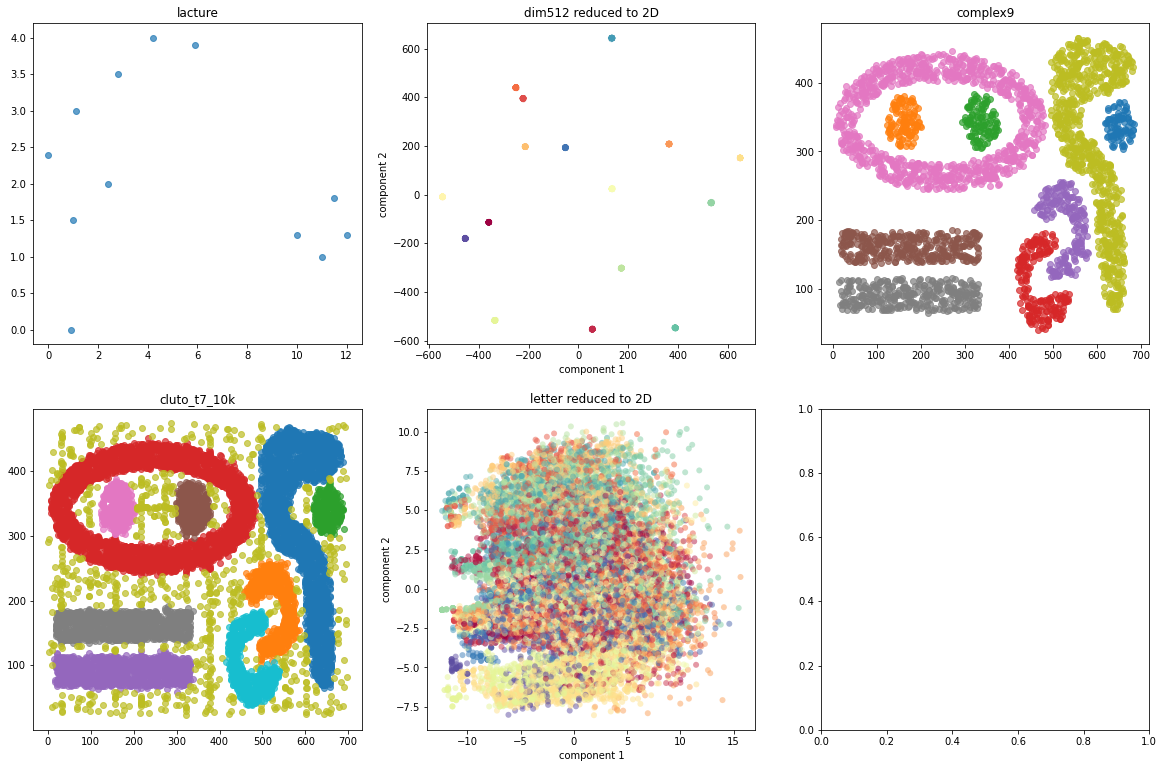

In [48]:
_, ax = plt.subplots(2,3, figsize=(20,13))
plot_2d(lacture, 'lacture', ax=ax[0,0])
plot_nd(dim512, ax=ax[0,1]); ax[0,1].set_title('dim512 reduced to 2D')
plot_2d(complex9, 'complex9', ax=ax[0,2])
plot_2d(cluto_t7_10k, 'cluto_t7_10k', ax=ax[1,0])
plot_nd(letter, ax=ax[1,1]); ax[1,1].set_title('letter reduced to 2D')
plt.show()

# 3) User's Manual 

To run the program, open the Jupyter Notebook file named **“DAMI_Project.ipynb”**, from this link: https://github.com/rauzansumara/dbscan-and-dbscanrn-tanimoto-distance. This interactive Jupyter Notebook saved the results from previous run by us. Users can modify and run each cell from top to bottom to view the result of the code.  Note that this action will replace previous output plots. 

# 3) Results

We conducted our experiment using python programming language. Once you open the project folder, you will be presented with the following directory structure:

```
$ tree-project-folder
.
├── datasets
│   ├── cluto-t7-10k.arff
│   ├── complex9.arff
│   ├── dim512.pa
│   ├── dim512.ts
│   ├── dim512.txt
│   ├── lecture.csv
│   └── letter.arff
├── images
│   ├── datasets.png
│   ├── dbscan_cluto_t7_10k.png
│   ├── dbscan_complex9.png
│   ├── dbscan_dim512.png
│   ├── dbscan_lacture.png
│   ├── dbscan_letter.png
│   ├── dbscanrn_cluto_t7_10k.png
│   ├── dbscanrn_complex9.png
│   ├── dbscanrn_dim512.png
│   ├── ……………
│   └── optdbscanrn_letter.png
├── docs
│   └── documentation [report]
├── save_file
│   ├── DEBUG_dbscanrn_cluto_t7_10k_D2_R10000_k10.csv
│   ├── DEBUG_dbscanrn_complex9_D2_R3031_k9.csv
│   ├── DEBUG_dbscanrn_dim512_D512_R1024_k4.csv
│   ├── DEBUG_dbscanrn_lacture_D2_R12_k2.csv
│   ├── DEBUG_dbscanrn_letter_D16_R20000_k17.csv
│   ├── DEBUG_dbscanrn_cluto_t7_10k_D2_R10000_k10.csv
│   ├── ……………
│   ├── STAT_dbscan.csv
│   ├── STAT_dbscanrn.csv
│   └── STAT_Opt_dbscanrn.csv
├── DAMI_project.ipynb
```

The datasets directory contains the data used. The images directory contains visualization graph of each experiment. We also have docs directory providing report file, and the most significant things are the save_file directory storing the DEBUG, OUTPUT, and STAT files

### Using DBSCAN

In this section, we did some set of experiments using DBSCAN algorithm as follow:  
- lacture dataset - DBSCAN(lacture, eps=0.80, MinPts=4)
- dim512 dataset - DBSCAN(dim512, eps=0.80, MinPts=5)
- complex9 dataset - DBSCAN(complex9, eps=0.9995, MinPts=5)
- cluto_t7_10k dataset - DBSCAN(cluto_t7_10k, eps=0.99975, MinPts=6)
- letter dataset - DBSCAN(letter, eps=0.99975, MinPts=7)


#### *1) Plot Comparison*

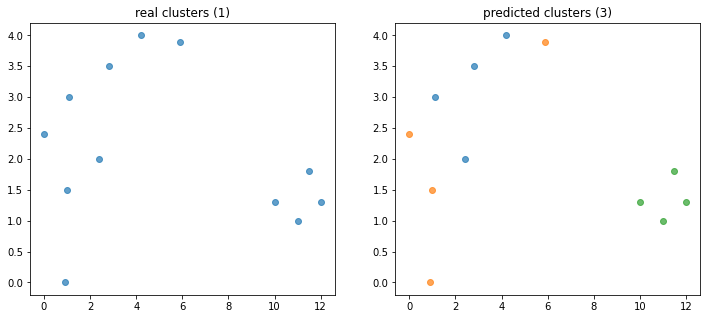

In [403]:
# lacture dataset
dbscan_lacture, t_lacture = DBSCAN(lacture, eps=0.80, MinPts=4)
plot_compare(dbscan_lacture)

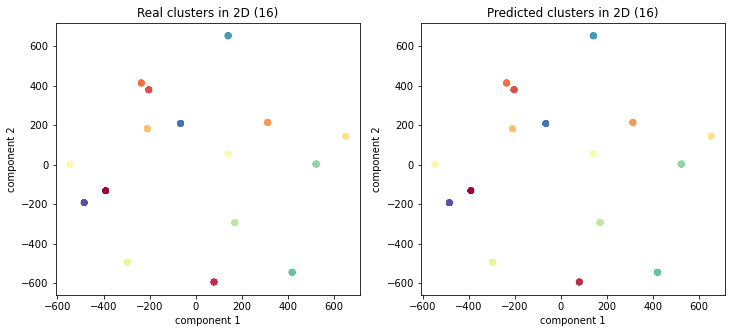

In [404]:
# dim512 dataset
dbscan_dim512, t_dim512 = DBSCAN(dim512, eps=0.80, MinPts=5)
plot_high_d(dbscan_dim512); plt.show()

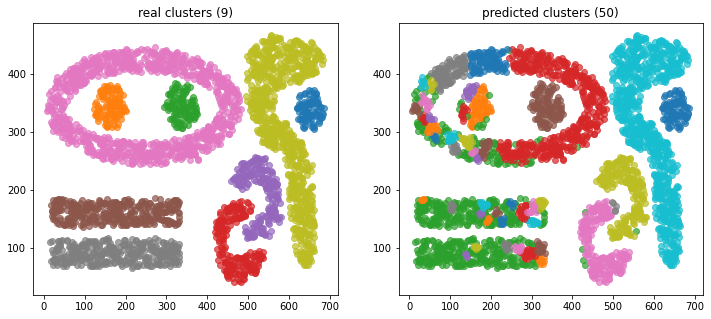

In [405]:
# complex9 dataset
dbscan_complex9, t_complex9 = DBSCAN(complex9, eps=0.9995, MinPts=5)
plot_compare(dbscan_complex9)

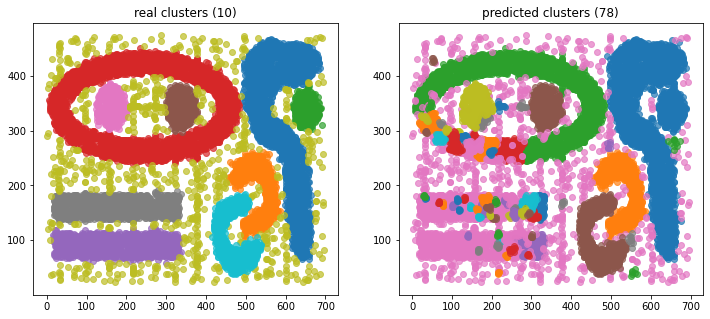

In [406]:
# cluto_t7_10k dataset
dbscan_cluto_t7_10k, t_cluto_t7_10k = DBSCAN(cluto_t7_10k, eps=0.99975, MinPts=6)
plot_compare(dbscan_cluto_t7_10k)

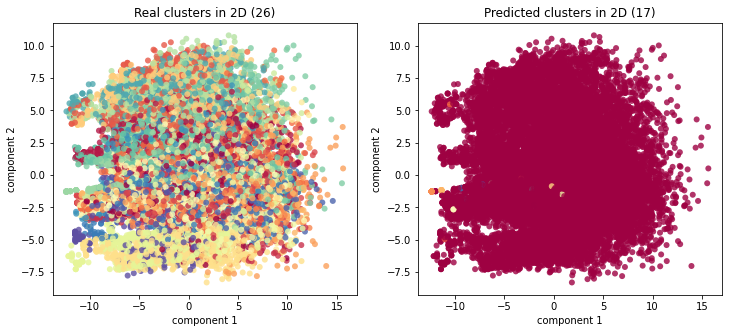

In [407]:
# letter dataset
dbscan_letter, t_letter = DBSCAN(letter, eps=0.99975, MinPts=7)
plot_high_d(dbscan_letter); plt.show()

#### *2) Quality Measures*

In [408]:
# STAT - save a file with the following statistics:
df = ds_prop.copy()
df['ClId'] = [len(dbscan_lacture['ClId'].unique()), len(dbscan_dim512['ClId'].unique()), 
                len(dbscan_complex9['ClId'].unique()), len(dbscan_cluto_t7_10k['ClId'].unique()), 
                len(dbscan_letter['ClId'].unique())]
tm = pd.DataFrame([t_lacture, t_dim512, t_complex9, t_cluto_t7_10k, t_letter], 
                columns = ['Reading_Time','Clustering_Time','Save_Time','Total_Time'])  
core = pd.DataFrame([count_type(dbscan_lacture), count_type(dbscan_dim512), count_type(dbscan_complex9), 
                    count_type(dbscan_cluto_t7_10k), count_type(dbscan_letter)], 
                    columns = ['Core_Point','Border_Point','Noise_Point'])
qm = pd.DataFrame([print_metric(dbscan_lacture), print_metric(dbscan_dim512), print_metric(dbscan_complex9), 
                print_metric(dbscan_cluto_t7_10k), print_metric(dbscan_letter)], 
                columns = ['Purity_Index','Rand_Index', 'DaviesBouldin_Index','Silhouette_Score'])
count_type
stat = pd.concat([df, core, tm, qm], axis=1)
stat['Reading_Time'], stat['Total_Time']  = stat['Reading_Time'] + Ri, stat['Total_Time'] + Ri
stat.to_csv(f'save_file/STAT_dbscan.csv', index=False)
stat

,Dataset,Size,Dimension,Cardinality,ClId,Core_Point,Border_Point,Noise_Point,Reading_Time,Clustering_Time,Save_Time,Total_Time,Purity_Index,Rand_Index,DaviesBouldin_Index,Silhouette_Score
0,lacture,12,2,<NA>,3,5,3,4,0.004002,0.001989,0.001999,0.007991,0.916667,0.893939,1.905921,0.337355
1,dim512,1024,512,16,16,1024,0,0,0.620927,17.812995,0.075964,18.509887,1.000000,0.061584,0.020462,0.986691
2,complex9,3031,2,9,50,2160,306,565,0.036099,51.045889,0.011995,51.093983,0.916529,0.565266,1.255038,-0.089414
3,cluto_t7_10k,10000,2,10,78,7065,793,2142,0.114168,667.353465,0.032015,667.499647,0.933300,0.593961,2.629512,-0.307721
4,letter,20000,16,26,17,156,0,19844,0.452215,2475.006246,0.332090,2475.790551,1.000000,0.999944,1.117191,-0.332474


As we can see from table above, we found 3 cluster in lacture dataset (include Noise). From 12 points, we got 4 core points, 3 border points, and 4 noise points. The total of running time is 0.007991 seconds, and so do the other detasets. We obtained also the quality measurement such as Purity_Index, Rand_Index, DaviesBouldin_Index, and Silhouette_Score

### Using DBSCANRN (Non-Optimized Version)

In Implementation of this algorithm both non-optimized and optimized version, we did some set of experiments as follow:  
- lecture dataset - DBSCANRN(lecture, k=2)
- im512 dataset - DBSCANRN(dim512, k=4)
- complex9 dataset - DBSCANRN(complex9, k=9)
- cluto_t7_10k dataset - DBSCANRN(cluto_t7_10k, k=10)
- letter dataset - DBSCANRN(letter, k=17)

#### *1) Plot Comparison*

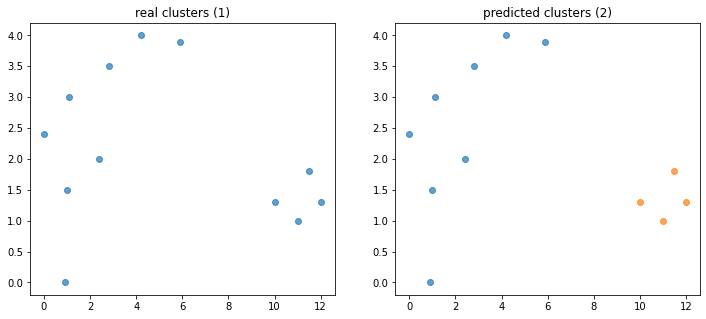

In [359]:
# lacture dataset
dbscanrn_lacture, nt_lacture = DBSCANRN(lacture, k=2, opt=False)
plot_compare(dbscanrn_lacture)

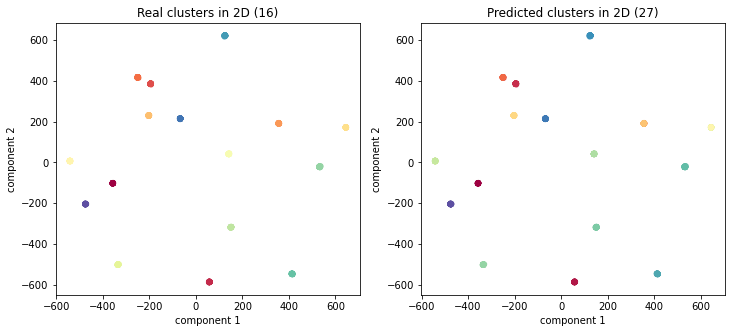

In [360]:
# dim512 dataset
dbscanrn_dim512, nt_dim512 = DBSCANRN(dim512, k=4, opt=False)
plot_high_d(dbscanrn_dim512); plt.show()

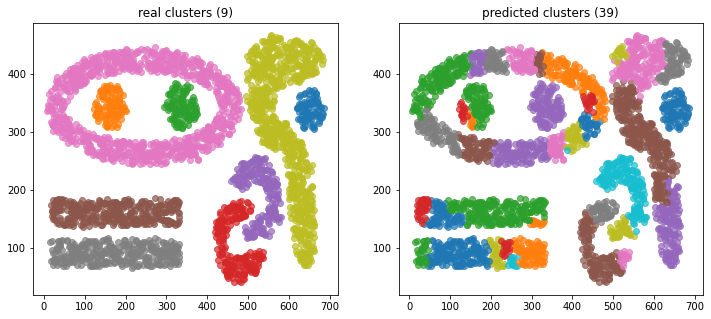

In [357]:
# complex9 dataset
dbscanrn_complex9, nt_complex9 = DBSCANRN(complex9, k=9, opt=False)
plot_compare(dbscanrn_complex9)

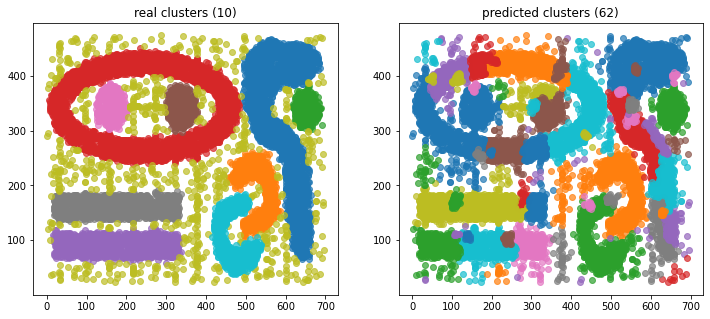

In [361]:
# cluto_t7_10k dataset
dbscanrn_cluto_t7_10k, nt_cluto_t7_10k = DBSCANRN(cluto_t7_10k, k=10, opt=False)
plot_compare(dbscanrn_cluto_t7_10k)

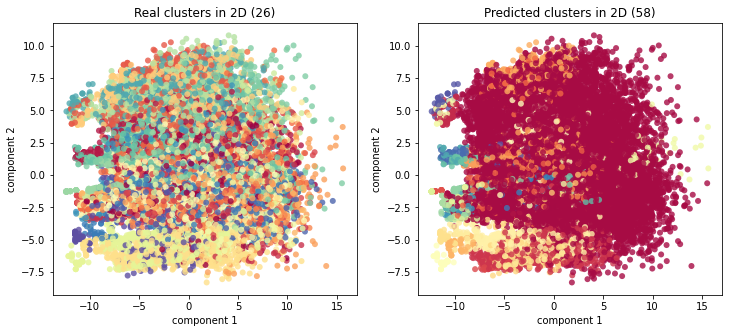

In [362]:
# letter dataset
dbscanrn_letter, nt_letter = DBSCANRN(letter, k=17, opt=False)
plot_high_d(dbscanrn_letter); plt.show()

#### *2) Quality Measures*

In [363]:
# STAT - save a file with the following statistics:
df = ds_prop.copy()
df['ClId'] = [len(dbscanrn_lacture['ClId'].unique()), len(dbscanrn_dim512['ClId'].unique()), 
                len(dbscanrn_complex9['ClId'].unique()), len(dbscanrn_cluto_t7_10k['ClId'].unique()), 
                len(dbscanrn_letter['ClId'].unique())]
tm = pd.DataFrame([nt_lacture, nt_dim512, nt_complex9, nt_cluto_t7_10k, nt_letter], 
                columns = ['Reading_Time','kNN/rkNN_Time','Clustering_Time','Save_Time','Total_Time'])
core = pd.DataFrame([count_type(dbscanrn_lacture), count_type(dbscanrn_dim512), count_type(dbscanrn_complex9), 
                    count_type(dbscanrn_cluto_t7_10k), count_type(dbscanrn_letter)], 
                    columns = ['Core_Point','Border_Point','Noise_Point'])                      
qm = pd.DataFrame([print_metric(dbscanrn_lacture), print_metric(dbscanrn_dim512), print_metric(dbscanrn_complex9), 
                print_metric(dbscanrn_cluto_t7_10k), print_metric(dbscanrn_letter)], 
                columns = ['Purity_Index','Rand_Index', 'DaviesBouldin_Index','Silhouette_Score'])

stat = pd.concat([df, core, tm, qm], axis=1)
stat['Reading_Time'], stat['Total_Time']  = stat['Reading_Time'] + Ri, stat['Total_Time'] + Ri
stat.to_csv(f'save_file/STAT_dbscanrn.csv', index=False)
stat

,Dataset,Size,Dimension,Cardinality,ClId,Core_Point,Border_Point,Noise_Point,Reading_Time,kNN/rkNN_Time,Clustering_Time,Save_Time,Total_Time,Purity_Index,Rand_Index,DaviesBouldin_Index,Silhouette_Score
0,lacture,12,2,<NA>,2,8,4,0,0.004002,0.002001,0.000000,0.006001,0.012005,0.666667,0.454545,0.307556,0.713755
1,dim512,1024,512,16,27,209,815,0,0.619919,18.267762,0.001000,0.087137,18.975818,0.795898,0.344243,2.102505,0.708637
2,complex9,3031,2,9,39,1753,1277,1,0.035098,55.351149,0.004003,0.070135,55.460385,0.580666,0.489176,0.815071,0.210441
3,cluto_t7_10k,10000,2,10,62,5891,4077,32,0.113179,621.120478,0.014990,0.253114,621.501762,0.597100,0.488377,1.561321,-0.118104
4,letter,20000,16,26,58,9896,10098,6,0.449201,2615.576711,0.044013,0.953630,2617.023555,0.521900,0.500591,1.225597,-0.207850


### Using DBSCANRN (Optimized Version)


#### *1) Plot Comparison*

we can see in the plot below that the model predicted way too many clusters for `banana` (45 vs only 2 real clusters). We need to tweak the DBSCAN parameters to reduce this. In `c20` the model only missed 1 cluster (colored orange in the left plot)

C:\Users\rauzan\AppData\Local\Temp/ipykernel_11984/3315112324.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  alfa = (1/2)*((1+1/e)+np.sqrt((1+1/e)**2-4))


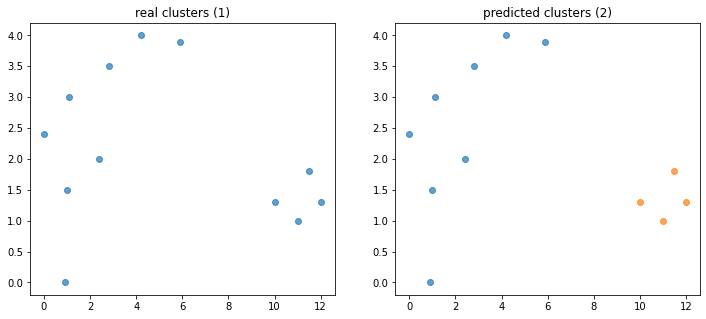

In [396]:
# lacture dataset
optdbscanrn_lacture, opt_lacture = DBSCANRN(lacture, k=2, opt=True)
plot_compare(optdbscanrn_lacture)

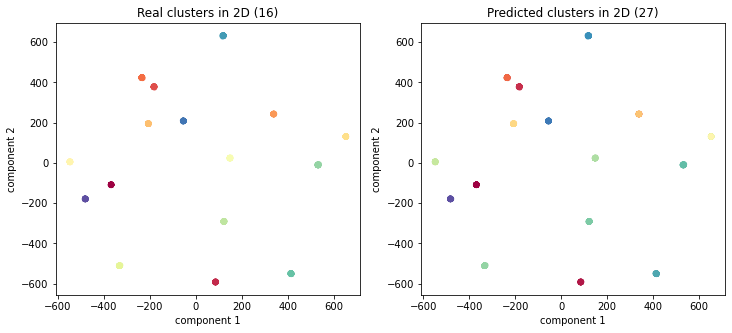

In [397]:
# dim512 dataset
optdbscanrn_dim512, opt_dim512 = DBSCANRN(dim512, k=4, opt=True)
plot_high_d(optdbscanrn_dim512); plt.show()

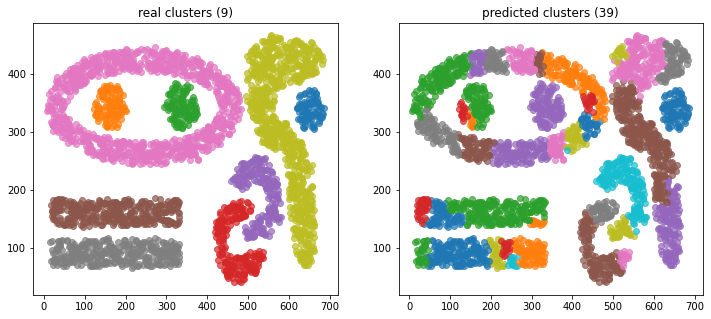

In [366]:
# complex9 dataset
optdbscanrn_complex9, opt_complex9 = DBSCANRN(complex9, k=9, opt=True)
plot_compare(optdbscanrn_complex9)

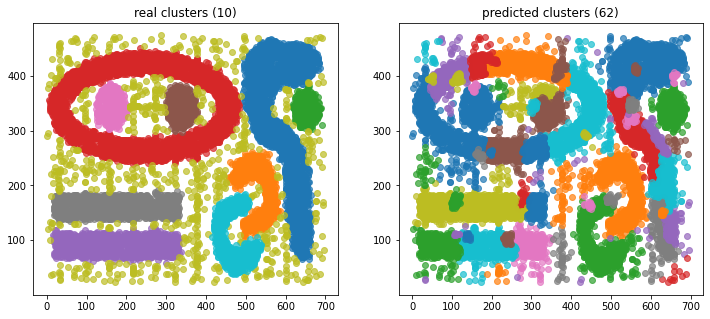

In [367]:
# cluto_t7_10k dataset
optdbscanrn_cluto_t7_10k, opt_cluto_t7_10k = DBSCANRN(cluto_t7_10k, k=10, opt=True)
plot_compare(optdbscanrn_cluto_t7_10k)

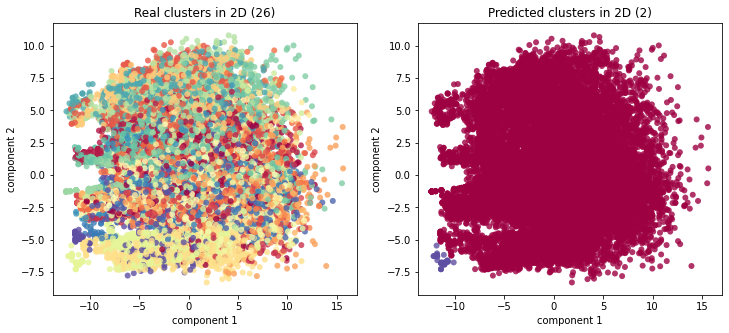

In [401]:
# letter dataset
optdbscanrn_letter, opt_letter = DBSCANRN(letter, k=17, opt=True)
plot_high_d(optdbscanrn_letter); plt.show()

#### *2) Quality Measures*

In [402]:
# STAT - save a file with the following statistics:
df = ds_prop.copy()
df['ClId'] = [len(optdbscanrn_lacture['ClId'].unique()), len(optdbscanrn_dim512['ClId'].unique()), 
                len(optdbscanrn_complex9['ClId'].unique()), len(optdbscanrn_cluto_t7_10k['ClId'].unique()), 
                len(optdbscanrn_letter['ClId'].unique())]
tm = pd.DataFrame([opt_lacture, opt_dim512, opt_complex9, opt_cluto_t7_10k, opt_letter], 
                columns = ['Reading_Time','kNN/rkNN_Time','Clustering_Time','Save_Time','Total_Time'])
core = pd.DataFrame([count_type(optdbscanrn_lacture), count_type(optdbscanrn_dim512), count_type(optdbscanrn_complex9), 
                    count_type(optdbscanrn_cluto_t7_10k), count_type(optdbscanrn_letter)], 
                    columns = ['Core_Point','Border_Point','Noise_Point'])        
qm = pd.DataFrame([print_metric(optdbscanrn_lacture), print_metric(optdbscanrn_dim512), print_metric(optdbscanrn_complex9), 
                print_metric(optdbscanrn_cluto_t7_10k), print_metric(optdbscanrn_letter)], 
                columns = ['Purity_Index','Rand_Index', 'DaviesBouldin_Index','Silhouette_Score'])

stat = pd.concat([df, core, tm, qm], axis=1)
stat['Reading_Time'], stat['Total_Time']  = stat['Reading_Time'] + Ri, stat['Total_Time'] + Ri
stat.to_csv(f'save_file/STAT_Opt_dbscanrn.csv', index=False)
stat

,Dataset,Size,Dimension,Cardinality,ClId,Core_Point,Border_Point,Noise_Point,Reading_Time,kNN/rkNN_Time,Clustering_Time,Save_Time,Total_Time,Purity_Index,Rand_Index,DaviesBouldin_Index,Silhouette_Score
0,lacture,12,2,<NA>,2,8,4,0,0.009998,0.000999,0.000000,0.014326,0.025323,0.666667,0.454545,0.307556,0.713755
1,dim512,1024,512,16,27,209,815,0,0.620907,5.269698,0.000998,0.088201,5.979804,0.795898,0.344243,2.102505,0.708637
2,complex9,3031,2,9,39,1753,1277,1,0.035098,7.095079,0.002089,0.066320,7.198586,0.580666,0.489176,0.815071,0.210441
3,cluto_t7_10k,10000,2,10,62,5891,4077,32,0.113179,31.629475,0.018149,0.316230,32.077034,0.597100,0.488377,1.561321,-0.118104
4,letter,20000,16,26,2,11614,8386,0,0.449209,1664.005344,0.053006,0.938037,1665.445597,0.580700,0.512648,0.770860,0.199443


As we can see from table of non-optimized version and table of optimized version, we found the same number predicted clusters and type of point (core, border or noise) on 4 datasets, such as lecture, dim512, complex9, and cluto_t7_10k datasets between non-optimized and optimized version. Unfortunately, we do not know why it showed different result on letter dataset between non-optimized version and optimized version. But apart from it, the comparison of DBSCANRN non-optimized and optimized version proven that the optimized version can reduce computation time up to 19 times faster than original non-optimized version. Meanwhile, the computation time does not really much different when we apply in small dataset like lecture dataset.

# 4) Conclusion



- in DBSCAN, computation time is affected by epsilon radius and size of dataset,
- in DBSCAN, larger epsilon creates more members of a cluster, while larger minPts usually creates a smaller number of clusters, 
- when running program/code with the same parameters on DBSCANRN both versions (non-optimized and optimized version), our implementation of optimized one successfully reduced computation time up to 19 times faster compared to non-optimized version, and
- We obtained different number of found clusters only in letter dataset when comparing non-optimized and optimized version of DBSCANRN. It could be caused of code or characteristics of the data itself; we need to investigate in the future.


# 5) Reference

[1] 	Chowdhury, S. and Amorim R.C., (2019) An efficient density-based clustering algorithm using reverse nearest neighbour. The Computing Conference 2019: London

[2] 	Kryszkiewicz M. (2021) Determining Tanimoto Similarity Neighborhoods of Real Valued Vectors by Means of the Triangle Inequality and Bounds on Lengths.

[3] 	Kryszkiewicz M., Lasek P. (2010) A Neighborhood-Based Clustering by Means of the Triangle Inequality. In: Fyfe C., Tino P., Charles D., Garcia-Osorio C., Yin H. (eds) Intelligent Data Engineering and Automated Learning – IDEAL 2010. IDEAL 2010

[4] 	Kryszkiewicz M. (2014) Using Non-Zero Dimensions and Lengths of Vectors for the Tanimoto Similarity Search among Real Valued Vectors. Springer International Publishing Switzerland 2014
